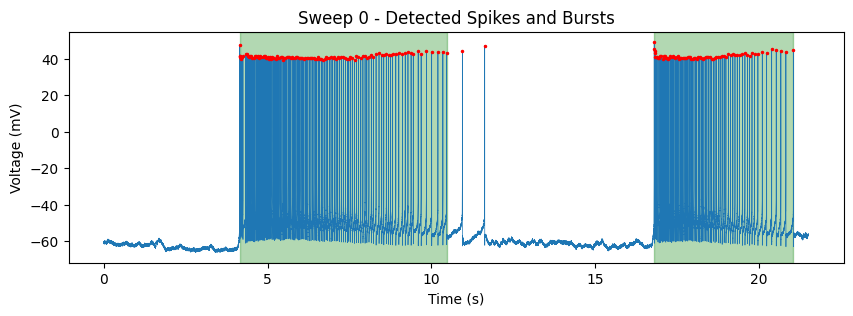

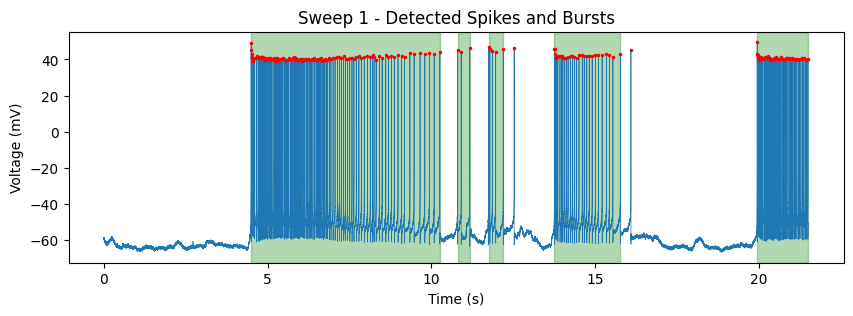

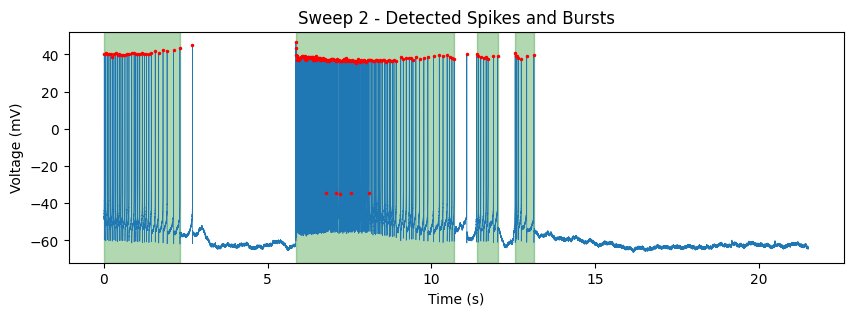

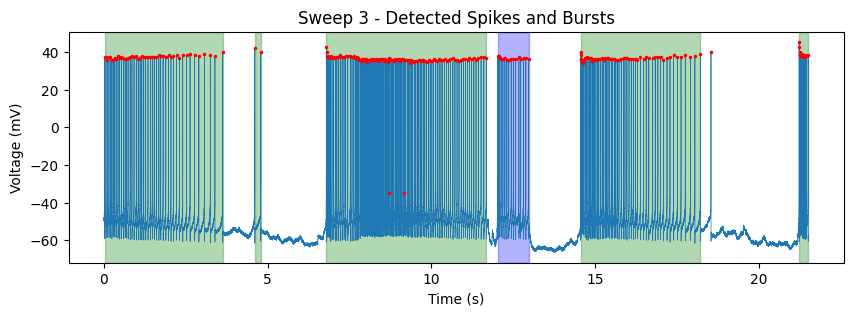

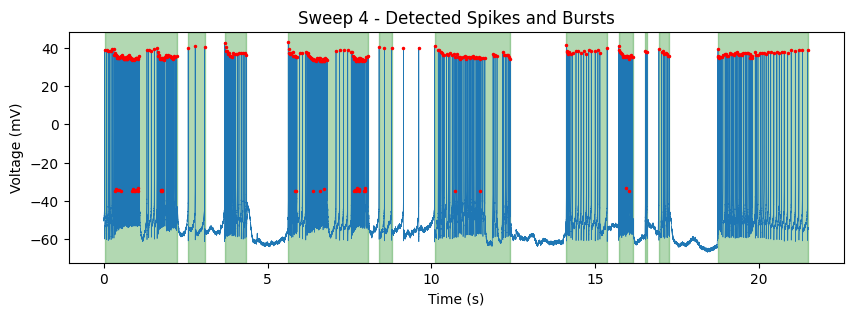

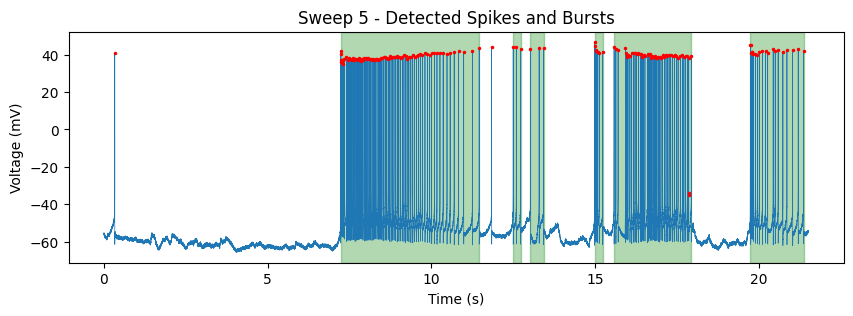

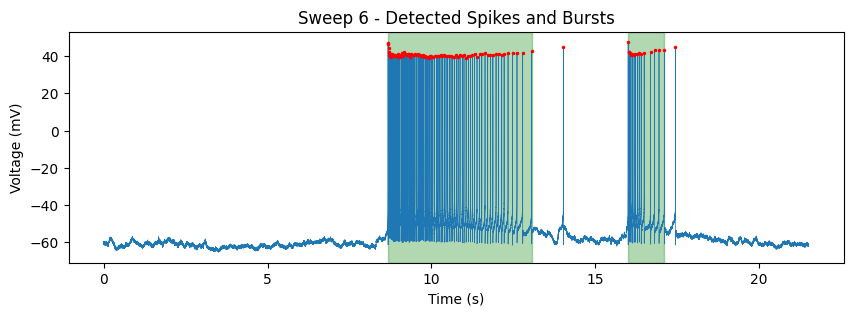

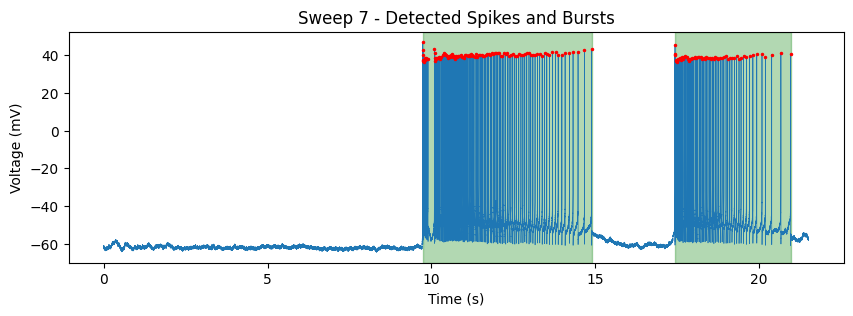

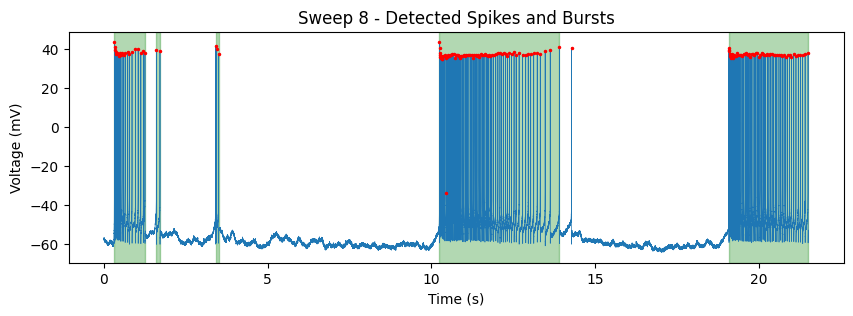

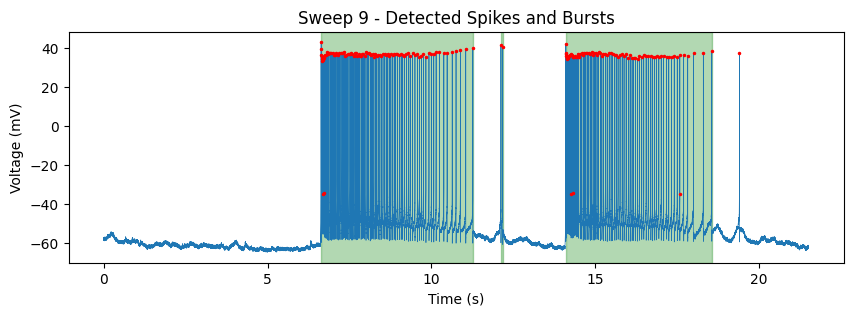

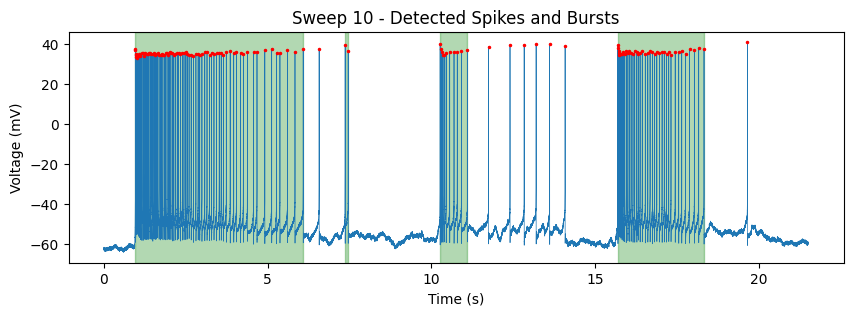

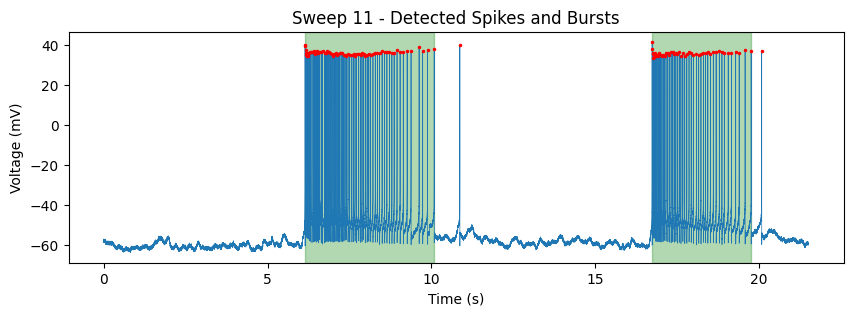

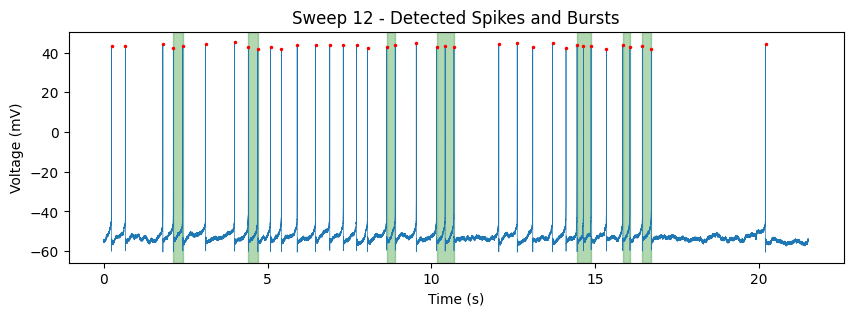

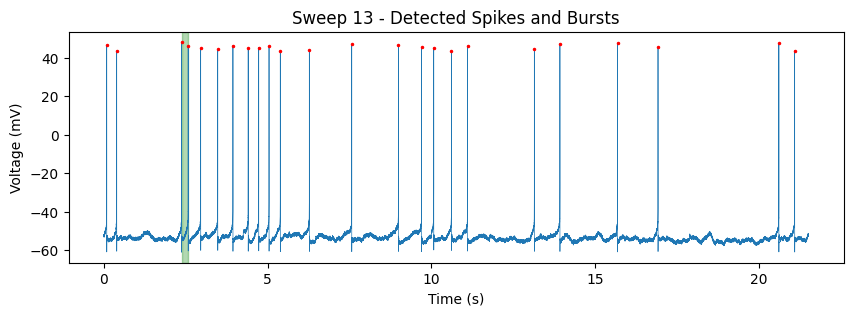

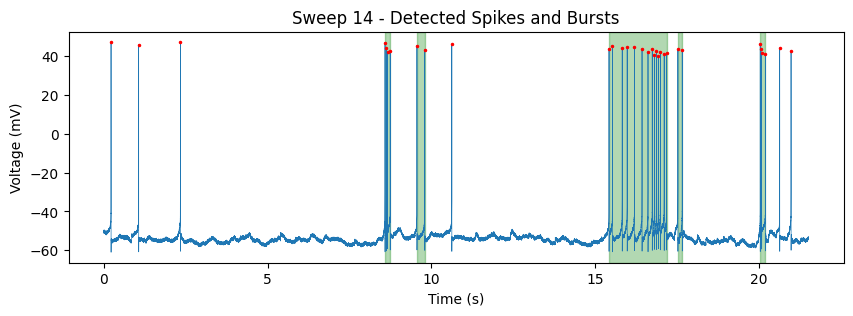

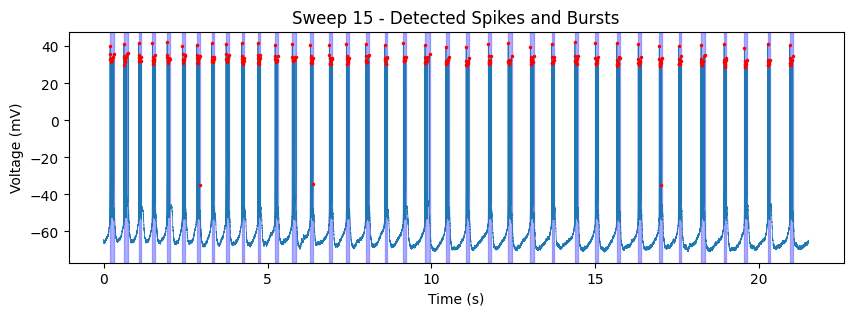

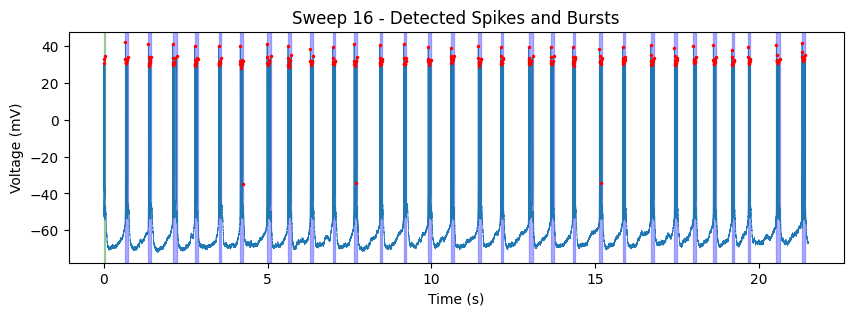

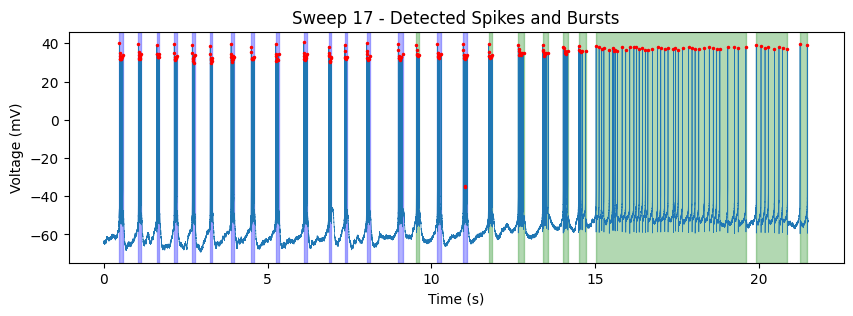

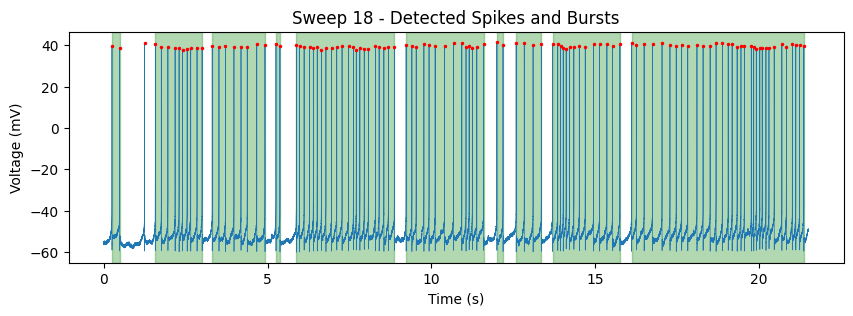

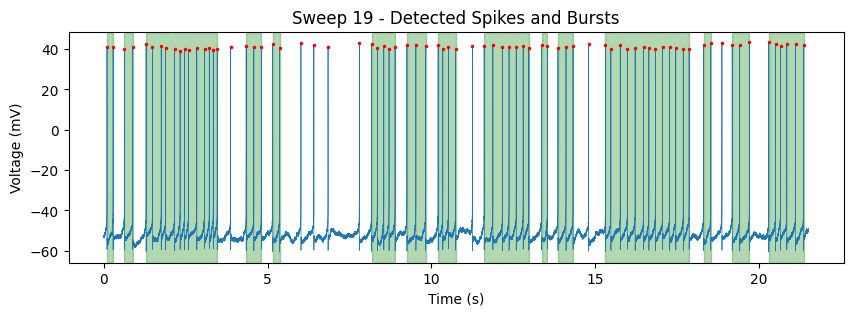

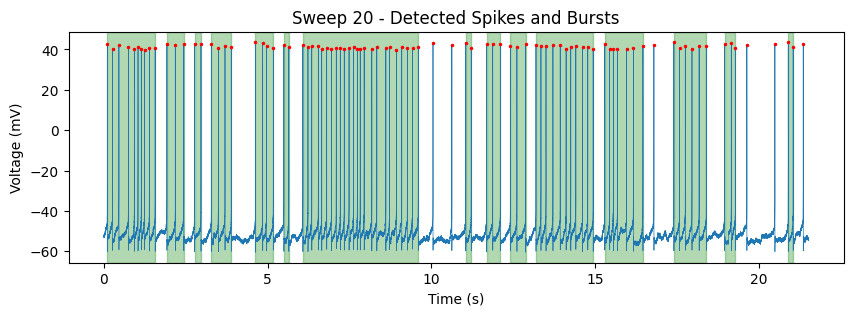

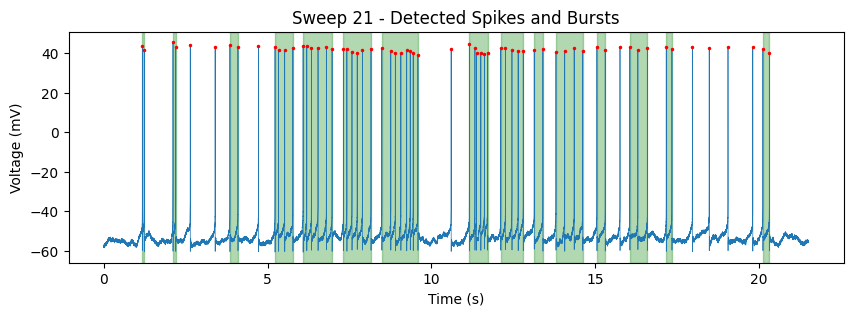

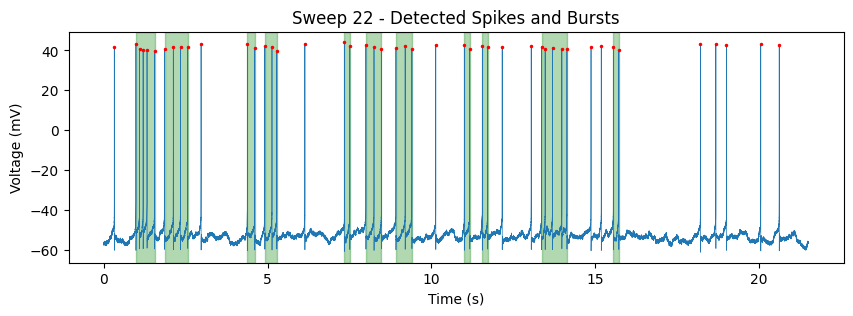

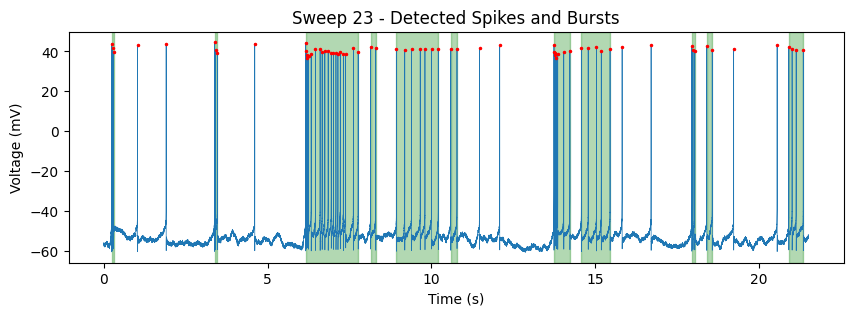

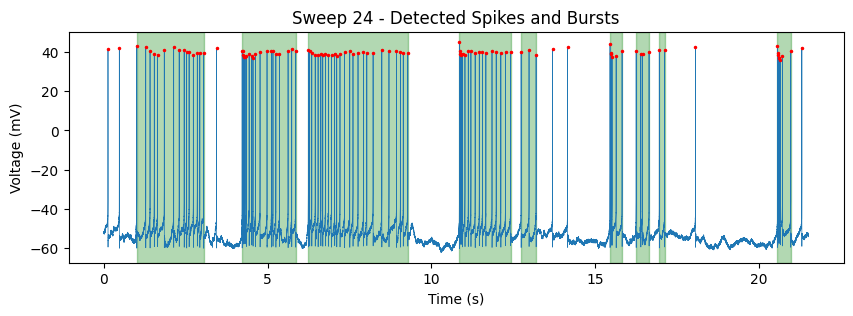

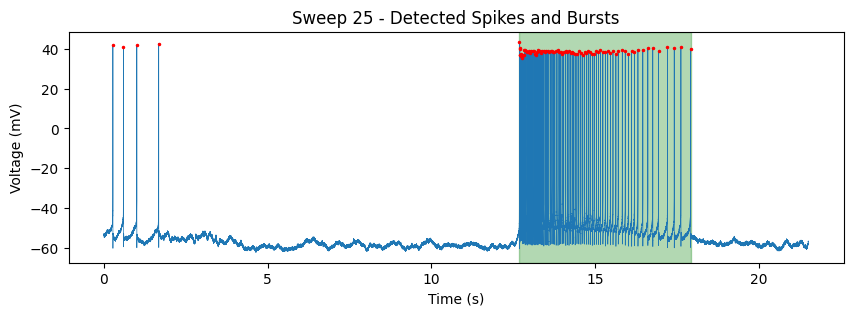

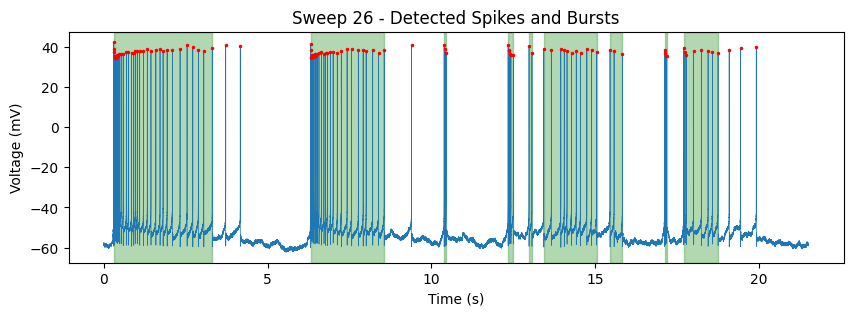

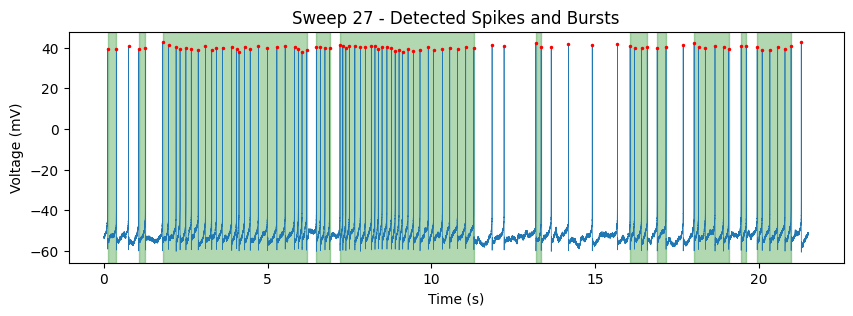

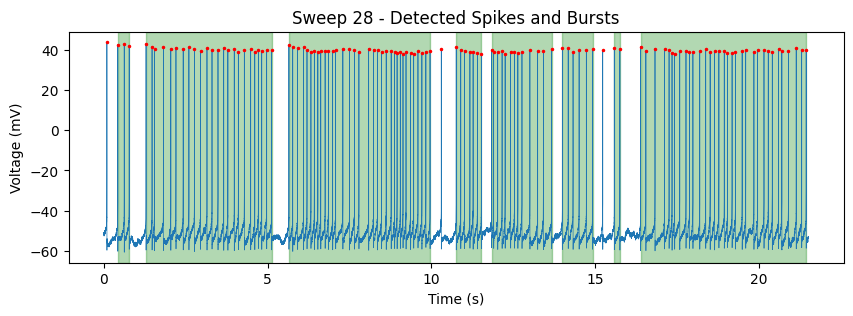

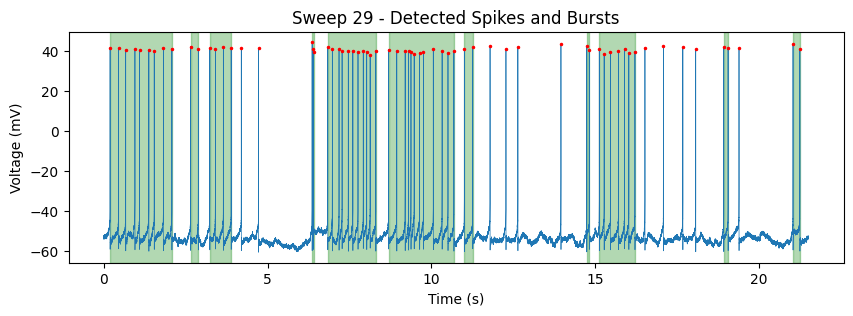

     Sweep  Start_Time_s  End_Time_s       Type
0        0        4.1492     10.4632  Parabolic
1        0       16.7984     21.0475  Parabolic
2        1        4.4975     10.2546  Parabolic
3        1       10.7976     11.1686  Parabolic
4        1       11.7434     12.1903  Parabolic
..     ...           ...         ...        ...
279     29       11.0038     11.2590  Parabolic
280     29       14.7392     14.8164  Parabolic
281     29       15.1217     16.2094  Parabolic
282     29       18.9200     19.0522  Parabolic
283     29       21.0337     21.2421  Parabolic

[284 rows x 4 columns]


In [1]:
#Recopilar info ycomprobar con reducción de dimensiones

import pyabf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load ABF file
file_path = "bursting/cell89basal.abf"
abf = pyabf.ABF(file_path)

dt = 1.0 / abf.dataRate

# Parameters
threshold = -35  # Spike detection threshold (mV)
burst_threshold = 0.3  # ISI threshold for burst detection (s)

all_bursts = []

for sweep in range(abf.sweepCount):
    abf.setSweep(sweep)
    signal = abf.sweepY
    time = abf.sweepX  # time for this sweep only

    # Spike detection
    spike_indices, _ = find_peaks(signal, height=threshold)
    spike_times = time[spike_indices]

    if len(spike_times) < 2:
        continue  # skip sweeps without spikes

    # Burst detection
    isi = np.diff(spike_times)
    bursts = []
    current_burst = [spike_times[0]]
    for i in range(1, len(spike_times)):
        if isi[i-1] < burst_threshold:
            current_burst.append(spike_times[i])
        else:
            if len(current_burst) > 1:
                bursts.append((current_burst[0], current_burst[-1]))
            current_burst = [spike_times[i]]
    if len(current_burst) > 1:
        bursts.append((current_burst[0], current_burst[-1]))

    # Burst classification
    square_wave_bursts = []
    parabolic_bursts = []
    other_bursts = []

    for i, (burst_start, burst_end) in enumerate(bursts):
        burst_mask = (time >= burst_start) & (time <= burst_end)
        burst_min = np.min(signal[burst_mask])

        prev_mean = np.mean(signal[(time < burst_start)]) if i == 0 else np.mean(signal[(time > bursts[i-1][1]) & (time < burst_start)])
        next_mean = np.mean(signal[(time > burst_end)]) if i == len(bursts)-1 else np.mean(signal[(time > burst_end) & (time < bursts[i+1][0])])
        inter_mean = np.nanmean([prev_mean, next_mean])

        if burst_min > inter_mean:
            square_wave_bursts.append((burst_start, burst_end))
            all_bursts.append([sweep, burst_start, burst_end, "Square Wave"])
        elif burst_min < inter_mean:
            parabolic_bursts.append((burst_start, burst_end))
            all_bursts.append([sweep, burst_start, burst_end, "Parabolic"])
        else:
            other_bursts.append((burst_start, burst_end))
            all_bursts.append([sweep, burst_start, burst_end, "Other"])

    # Plot sweep with bursts
    plt.figure(figsize=(10,3))
    plt.plot(time, signal, lw=0.5)
    plt.plot(spike_times, signal[spike_indices], 'r.', markersize=3)

    for start, end in square_wave_bursts:
        plt.axvspan(start, end, color='blue', alpha=0.3)
    for start, end in parabolic_bursts:
        plt.axvspan(start, end, color='green', alpha=0.3)
    for start, end in other_bursts:
        plt.axvspan(start, end, color='orange', alpha=0.3)

    plt.title(f"Sweep {sweep} - Detected Spikes and Bursts")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV)")
    plt.show()

# Save results to CSV
df_bursts = pd.DataFrame(all_bursts, columns=["Sweep", "Start_Time_s", "End_Time_s", "Type"])
df_bursts.to_csv("burst_info_by_sweep.csv", index=False)
print(df_bursts)


In [2]:
import pyabf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# === Parámetros ===
file_path = "bursting/cell89basal.abf"
abf = pyabf.ABF(file_path)
fs = int(abf.dataPointsPerMs * 1000)  # Hz
threshold = -35
prominence = 15
min_width = 0.3 * (fs / 1000)
min_distance = 1 * (fs / 1000)
burst_threshold = 0.3  # ISI máximo dentro de un burst (s)

all_segments = []

for sweep in abf.sweepList:
    abf.setSweep(sweep)
    time = abf.sweepX
    voltage = abf.sweepY

    # === Spike detection ===
    peaks, _ = find_peaks(
        voltage,
        height=threshold,
        threshold=threshold,
        distance=min_distance,
        prominence=prominence,
        width=min_width
    )
    spike_times = peaks / fs

    if len(spike_times) < 2:
        # sweep sin spikes = todo es Non-burst
        all_segments.append([sweep, "Non-burst", time[0], time[-1], "-"])
        continue

    isi = np.diff(spike_times)

    # === Burst detection ===
    bursts = []
    current_burst = [spike_times[0]]
    for i in range(1, len(spike_times)):
        if isi[i - 1] < burst_threshold:
            current_burst.append(spike_times[i])
        else:
            if len(current_burst) > 1:
                bursts.append((current_burst[0], current_burst[-1]))
            current_burst = [spike_times[i]]
    if len(current_burst) > 1:
        bursts.append((current_burst[0], current_burst[-1]))

    # === Clasificación de bursts ===
    classified_bursts = []
    for i, (burst_start, burst_end) in enumerate(bursts):
        burst_mask = (time >= burst_start) & (time <= burst_end)
        burst_min = np.min(voltage[burst_mask])

        if i > 0:
            prev_end = bursts[i - 1][1]
            prev_mean = np.mean(voltage[(time > prev_end) & (time < burst_start)])
        else:
            prev_mean = np.nan

        if i < len(bursts) - 1:
            next_start = bursts[i + 1][0]
            next_mean = np.mean(voltage[(time > burst_end) & (time < next_start)])
        else:
            next_mean = np.nan

        inter_mean = np.nanmean([prev_mean, next_mean])

        if burst_min > inter_mean:
            burst_type = "Square Wave"
        elif burst_min < inter_mean:
            burst_type = "Parabolic"
        else:
            burst_type = "Other"

        classified_bursts.append((burst_start, burst_end, burst_type))

    # === Guardar bursts como segmentos ===
    for start, end, btype in classified_bursts:
        all_segments.append([sweep, "Burst", start, end, btype])

    # === Guardar non-bursts ===
    if classified_bursts:
        # Antes del primer burst
        if classified_bursts[0][0] > time[0]:
            all_segments.append([sweep, "Non-burst", time[0], classified_bursts[0][0], "-"])
        # Entre bursts
        for i in range(len(classified_bursts) - 1):
            all_segments.append([sweep, "Non-burst",
                                 classified_bursts[i][1], classified_bursts[i+1][0], "-"])
        # Después del último burst
        if classified_bursts[-1][1] < time[-1]:
            all_segments.append([sweep, "Non-burst", classified_bursts[-1][1], time[-1], "-"])
    else:
        all_segments.append([sweep, "Non-burst", time[0], time[-1], "-"])

# === Guardar resultados ===
df_segments = pd.DataFrame(all_segments, 
                           columns=["Sweep", "Segment_Type", "Start_Time_s", "End_Time_s", "Burst_Type"])
df_segments.to_csv("segments_by_sweep.csv", index=False)
print(df_segments.head(20))

C:\Users\manur\AppData\Local\Temp\ipykernel_10940\953034561.py:73: RuntimeWarning: Mean of empty slice
  inter_mean = np.nanmean([prev_mean, next_mean])


    Sweep Segment_Type  Start_Time_s  End_Time_s   Burst_Type
0       0        Burst        4.1492     10.4632    Parabolic
1       0        Burst       16.7984     21.0475    Parabolic
2       0    Non-burst        0.0000      4.1492            -
3       0    Non-burst       10.4632     16.7984            -
4       0    Non-burst       21.0475     21.4999            -
5       1        Burst        4.4975     10.2546    Parabolic
6       1        Burst       10.7976     11.1686    Parabolic
7       1        Burst       11.7434     12.1903    Parabolic
8       1        Burst       13.7539     15.7636    Parabolic
9       1        Burst       19.9399     21.4873  Square Wave
10      1    Non-burst        0.0000      4.4975            -
11      1    Non-burst       10.2546     10.7976            -
12      1    Non-burst       11.1686     11.7434            -
13      1    Non-burst       12.1903     13.7539            -
14      1    Non-burst       15.7636     19.9399            -
15      

In [3]:
import os
import pyabf
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

# === Parámetros ===
folder_path = "bursting"  # Carpeta con todos los ABF
threshold = -35           # umbral de spike real
burst_threshold = 0.3     # s
fs = 10000                # frecuencia de muestreo
dt = 1 / fs               # paso temporal para np.trapz

all_segment_metrics = []

# Listar todos los archivos ABF
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]

for file_name in abf_files:
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)

    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)
        time = abf.sweepX
        voltage = abf.sweepY

        # === Spike detection (para detectar bursts) ===
        peaks, _ = find_peaks(voltage, height=threshold)
        spike_times = peaks / fs

        # === Burst detection ===
        bursts = []
        if len(spike_times) >= 2:
            isi = np.diff(spike_times)
            current_burst = [spike_times[0]]
            for i in range(1, len(spike_times)):
                if isi[i - 1] < burst_threshold:
                    current_burst.append(spike_times[i])
                else:
                    if len(current_burst) > 1:
                        bursts.append((current_burst[0], current_burst[-1]))
                    current_burst = [spike_times[i]]
            if len(current_burst) > 1:
                bursts.append((current_burst[0], current_burst[-1]))

        # === Segments (bursts + non-bursts) ===
        segments = []
        for start, end in bursts:
            segments.append((start, end, "Burst"))
        if bursts:
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            for i in range(len(bursts) - 1):
                segments.append((bursts[i][1], bursts[i+1][0], "Non-burst"))
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            segments.append((time[0], time[-1], "Non-burst"))

        # === Métricas por segmento ===
        for (seg_start, seg_end, seg_type) in segments:
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]
            duration = seg_end - seg_start

            # Métricas voltaje
            if len(seg_voltage) < 2:
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
            else:
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                area_val = np.trapz(seg_voltage, dx=dt)

            # Métricas derivada
            if len(seg_voltage) < 2:
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                deriv = np.diff(seg_voltage) / dt
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)

            all_segment_metrics.append([
                file_name, sweep, seg_type, duration,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])

# === DataFrame final y guardado ===
df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Duration",
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv", "Skewness_Deriv", "Kurtosis_Deriv"
])

df_segments.to_csv("segment_voltage_metrics_with_deriv.csv", index=False)


C:\Users\manur\AppData\Local\Temp\ipykernel_10940\1608840067.py:78: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_val = np.trapz(seg_voltage, dx=dt)


C:\Users\manur\AppData\Local\Temp\ipykernel_10940\359803876.py:100: RuntimeWarning:

Mean of empty slice

c:\Users\manur\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



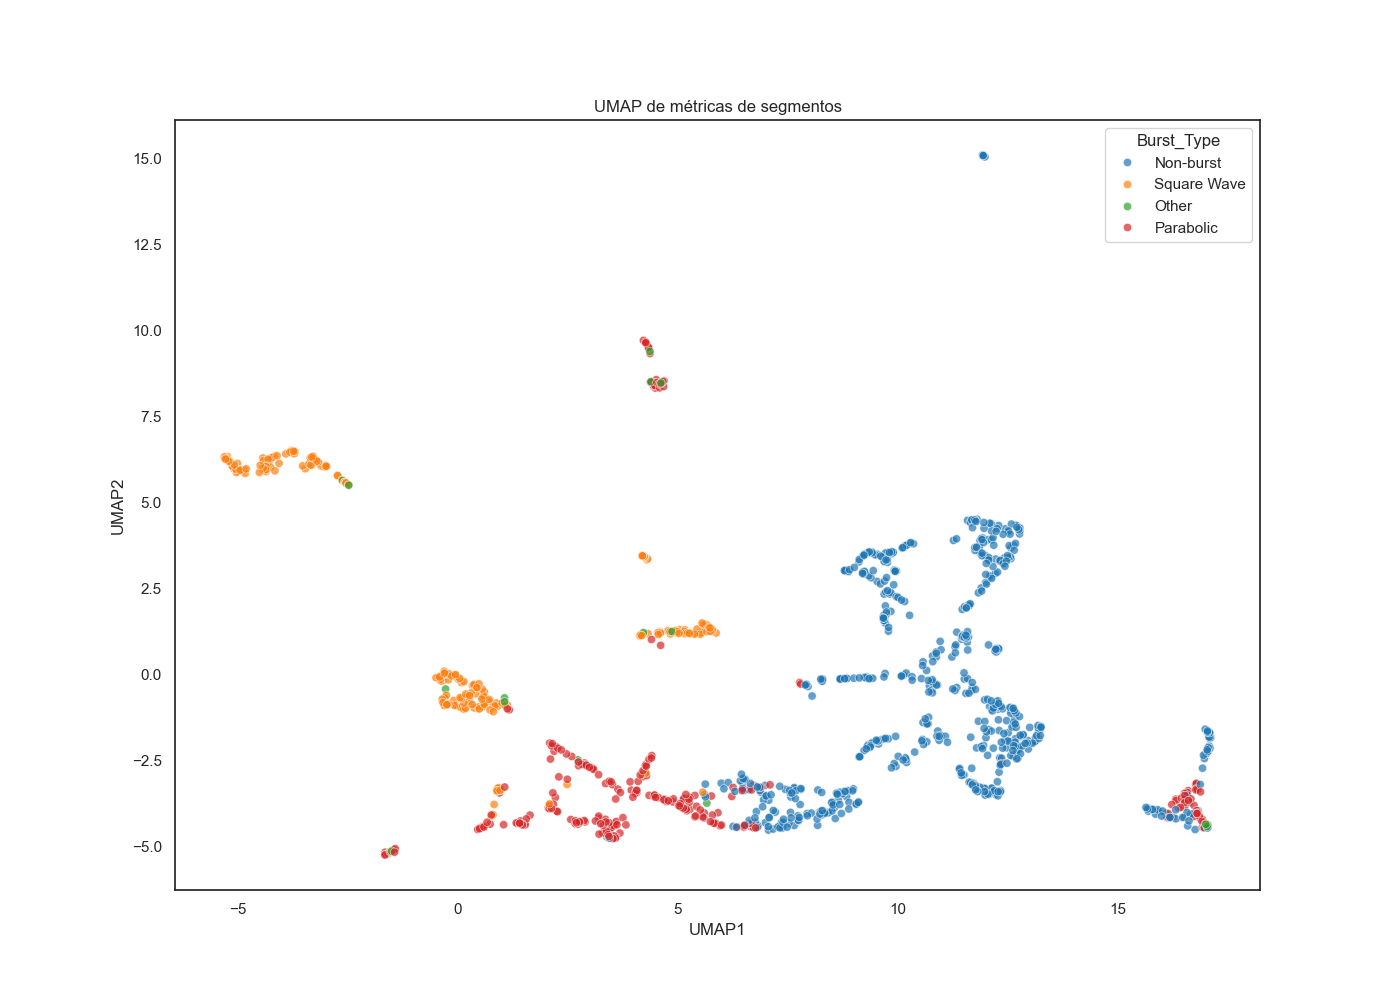

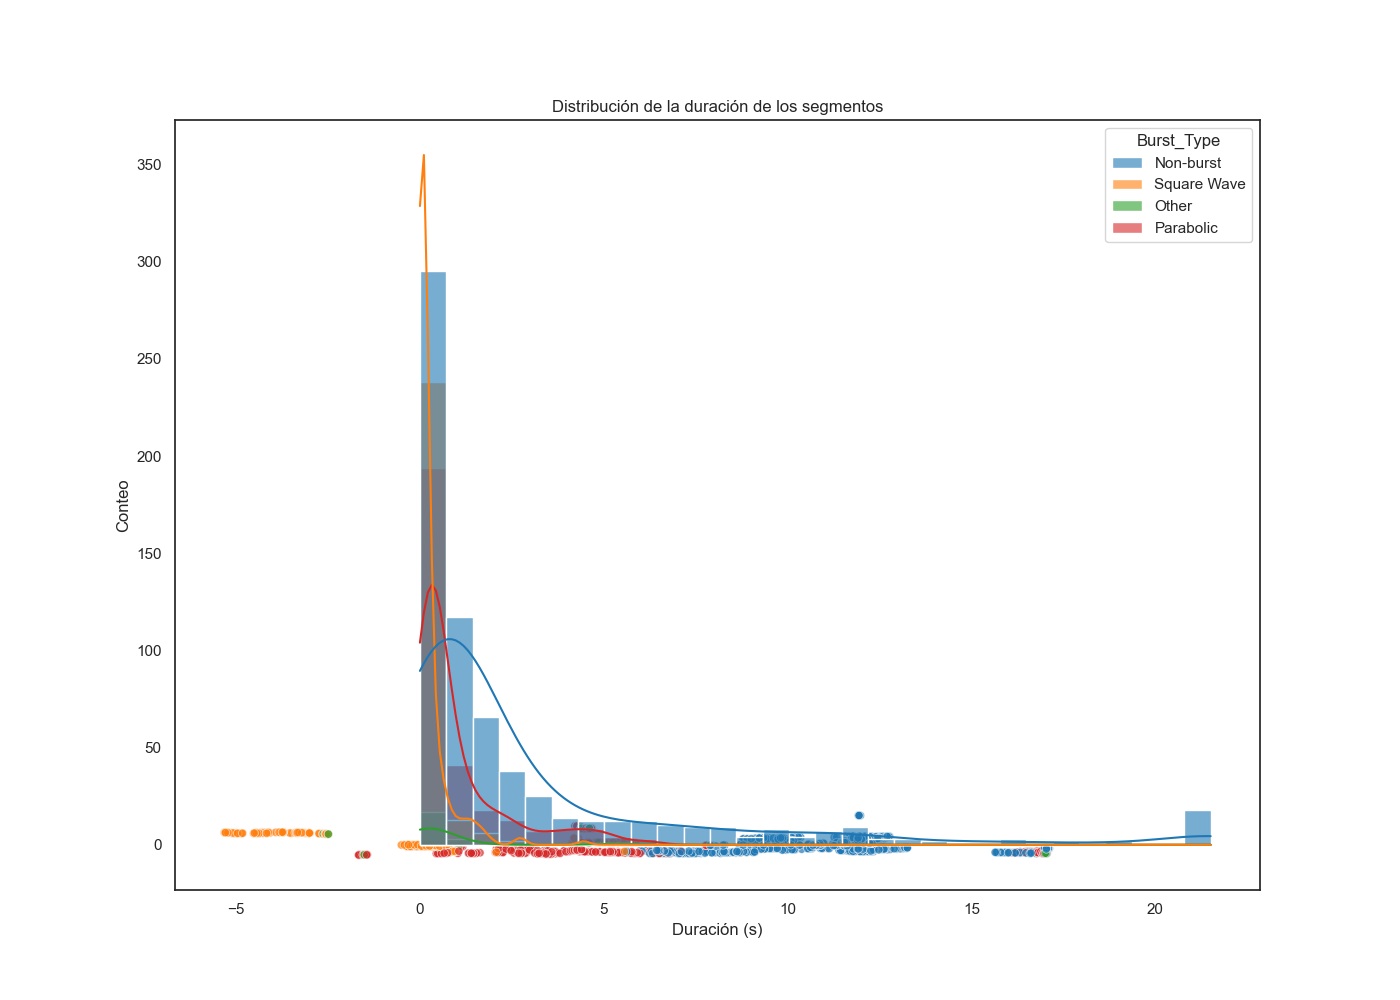

In [4]:
#Load libraries
import os #This library is used for operating with directories and documents 
import pyabf
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
%matplotlib widget

# UMAP y ML
import umap
from sklearn.preprocessing import StandardScaler #This will be used for scaling the obtained data

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

# This forces Plotly to open the graph in navigator
# I had compatibility problems with the library, even though I used the plotly without the express
pio.renderers.default = "browser"


#Parameters
folder_path = "bursting"  #Folder with ABF
threshold = -35          
burst_threshold = 0.3    
fs = 10000                # sample freq.
dt = 1 / fs               

all_segment_metrics = []


#ABF files processing
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")] 

for file_name in abf_files:
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)

    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)
        time = abf.sweepX
        voltage = abf.sweepY

        #Spike detection
        peaks, _ = find_peaks(voltage, height=threshold)
        spike_times = peaks / fs

        #Burst detection
        bursts = []
        if len(spike_times) >= 2:
            isi = np.diff(spike_times)
            current_burst = [spike_times[0]]
            for i in range(1, len(spike_times)):
                if isi[i - 1] < burst_threshold:
                    current_burst.append(spike_times[i])
                else:
                    if len(current_burst) > 1:
                        bursts.append((current_burst[0], current_burst[-1]))
                    current_burst = [spike_times[i]]
            if len(current_burst) > 1:
                bursts.append((current_burst[0], current_burst[-1]))

                
        #Segments: bursts and non-bursts
        segments = []
        for start, end in bursts:
            segments.append((start, end, "Burst"))
        if bursts:
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            for i in range(len(bursts) - 1):
                segments.append((bursts[i][1], bursts[i+1][0], "Non-burst"))
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            segments.append((time[0], time[-1], "Non-burst"))
        
        #Burst type
        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):
            
            if seg_type == "Burst":
                seg_mask = (time >= seg_start) & (time <= seg_end)
                burst_min = np.min(voltage[seg_mask])
                prev_mean = np.nan
                next_mean = np.nan
                if i > 0:
                    prev_end = segments[i-1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments)-1:
                    next_start = segments[i+1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])
                inter_mean = np.nanmean([prev_mean, next_mean])
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                burst_type = "Non-burst"
            burst_types.append(burst_type)

        # Métricas por segmento
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]
            duration = seg_end - seg_start
            burst_type = burst_types[j]

            # Picos dentro del segmento
            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)
            mean_isi = np.mean(np.diff(seg_peaks / fs)) if num_peaks >= 2 else 0

            # Métricas voltaje
            if len(seg_voltage) < 2:
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
            else:
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                area_val = np.trapezoid(seg_voltage, dx=dt)

            # Métricas derivada
            if len(seg_voltage) < 2:
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                deriv = np.diff(seg_voltage) / dt
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)

            all_segment_metrics.append([
                file_name, sweep, seg_type, burst_type, duration,
                num_peaks, mean_isi,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])

# === DataFrame final y guardado ===
df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration",
    "Num_Peaks", "Mean_ISI",
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv", "Skewness_Deriv", "Kurtosis_Deriv"
])
df_segments.to_csv("segment_voltage_metrics_with_ISI_and_peaks.csv", index=False)

# === UMAP Section ===
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
df = pd.read_csv("segment_voltage_metrics_with_ISI_and_peaks.csv")

# Variables numéricas y etiquetas
header = list(df)[4:]    # desde "Duration"
X = np.array(df[header])
y = np.array(df.Burst_Type)

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Guardar en DataFrame
df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_umap["Burst_Type"] = y

# === Visualización con Seaborn (scatter) ===
sns.scatterplot(
    data=df_umap, x="UMAP1", y="UMAP2",
    hue="Burst_Type", palette="tab10", alpha=0.7
)
plt.title("UMAP de métricas de segmentos")
plt.show()

# === Histograma interactivo con Seaborn ===
sns.set(style="whitegrid", context="notebook", rc={'figure.figsize':(10,6)})
sns.histplot(
    data=df_segments,
    x="Duration",
    hue="Burst_Type",
    bins=30,
    kde=True,
    palette="tab10",
    alpha=0.6
)
plt.title("Distribución de la duración de los segmentos")
plt.xlabel("Duración (s)")
plt.ylabel("Conteo")
plt.show()

# === Visualización interactiva con Plotly ===
fig = px.scatter(
    df_umap, x="UMAP1", y="UMAP2",
    color="Burst_Type",
    title="UMAP interactivo de segmentos"
)
pio.renderers.default = "browser"
fig.show()
